<a href="https://colab.research.google.com/github/Indukurivigneshvarma/Deep_Learning/blob/main/Computer_Vision/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:4.0.0', with_info=True)
train = dataset['train']
test  = dataset['test']

from IPython.display import clear_output
clear_output(wait=True)

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128))
    input_mask  = tf.image.resize(input_mask,  (128, 128))
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask  = tf.cast(input_mask, tf.int32) - 1
    return input_image, input_mask

train = train.map(lambda x: normalize(x['image'], x['segmentation_mask']))
test  = test.map(lambda x: normalize(x['image'], x['segmentation_mask']))

train = train.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test  = test.batch(32)

In [5]:
from tensorflow.keras import layers, Model

def unet_model(output_channels:int):
    inputs = layers.Input(shape=[128,128,3])

    x1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D()(x1)

    x2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D()(x2)

    x3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)

    u1 = layers.Conv2DTranspose(128, 3, strides=2, activation='relu', padding='same')(x3)
    concat1 = layers.Concatenate()([u1, x2])

    u2 = layers.Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')(concat1)
    concat2 = layers.Concatenate()([u2, x1])

    outputs = layers.Conv2D(output_channels, 1, activation='softmax')(concat2)

    return Model(inputs, outputs)

model = unet_model(3)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    295,040 │ conv2d_2[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    147,520 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        387 │ concatenate_1[0]… │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 813,763 (3.10 MB)

 Trainable params: 813,763 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train, epochs=5, validation_data=test)

from IPython.display import clear_output
clear_output(wait=True)

Epoch 1/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 228ms/step - accuracy: 0.6088 - loss: 0.8849 - val_accuracy: 0.6754 - val_loss: 0.7502
Epoch 2/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 187ms/step - accuracy: 0.6722 - loss: 0.7286 - val_accuracy: 0.7106 - val_loss: 0.6883
Epoch 3/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.7191 - loss: 0.6539 - val_accuracy: 0.6990 - val_loss: 0.6681
Epoch 4/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.7381 - loss: 0.6195 - val_accuracy: 0.7545 - val_loss: 0.5927
Epoch 5/5
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.7507 - loss: 0.5938 - val_accuracy: 0.7436 - val_loss: 0.6077


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


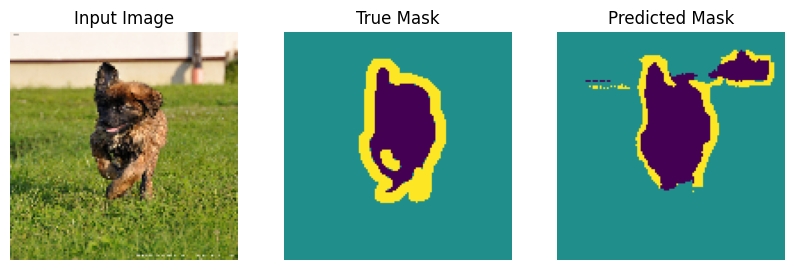

In [8]:
sample_img, sample_mask = next(iter(test.take(1)))
pred_mask = model.predict(sample_img)

def display(display_list):
    plt.figure(figsize=(10, 8))
    titles = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(titles[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

display([sample_img[0],
         sample_mask[0],
         tf.argmax(pred_mask[0], axis=-1)[..., tf.newaxis]])

In [9]:
model.save("unet_pet_segmentation.h5")

from IPython.display import clear_output
clear_output(wait=True)
print("Model trained and saved successfully!")

Model trained and saved successfully!


In [16]:
import tensorflow as tf
import matplotlib.pyplot as plt

img_path = "Pets.jpg"

image = tf.io.read_file(img_path)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, (128, 128))

input_image = tf.cast(image, tf.float32) / 255.0
input_image = tf.expand_dims(input_image, axis=0)

In [17]:
pred_mask = model.predict(input_image)
pred_mask = tf.argmax(pred_mask[0], axis=-1)[..., tf.newaxis]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


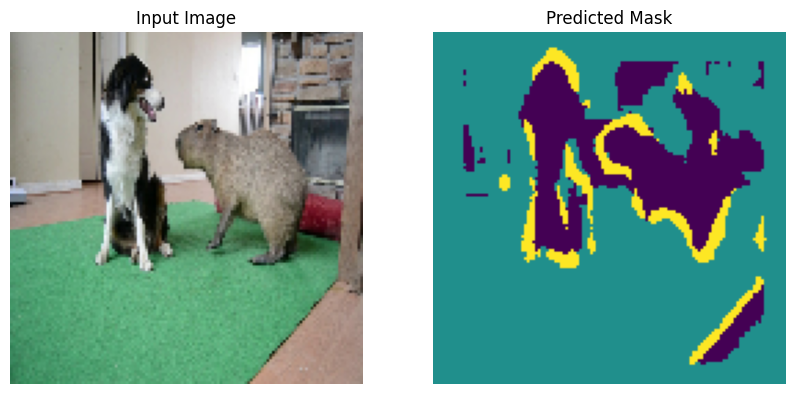

In [18]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title("Input Image")
plt.imshow(tf.keras.utils.array_to_img(image))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Predicted Mask")
plt.imshow(tf.keras.utils.array_to_img(pred_mask))
plt.axis('off')

plt.show()